In [323]:
import numpy as np
import pandas as pd
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

In [368]:
models_ran = [
    'LC_discrete_attention',
    'change_d_obs_fk',
    'change_d_obs_cause_effect',
    'change_d_obs_cause',
    'LC_discrete',
    'normative',
    'ces_strength',
    'ces_no_strength'
]

file_tags = [
    ['att', 'att_prior'],
    ['att_cha', 'att_cha_prior'],
    ['att_cha'],
    ['att_cha'],
    [1, 'prior_100'],
    [1, 'prior'],
    [1],
    [1]
]

model_labels = [
    ['LC w. attention', 'LC w. attention w. prior'],
    ['Change w. full knowledge', 'Change w. full knowledge w. prior'],
    ['Change linear cause effect'],
    ['Change linear cause'],
    ['LC basic', 'LC basic w. prior'],
    ['normative', 'normative w. prior'],
    ['CES strength sensitive'],
    ['CES basic']
]

model_names = []
for names in model_labels:
    model_names += names

color_dict = {
    'LC w. attention': sns.light_palette("seagreen").as_hex()[-1], 
    'LC w. attention w. prior': sns.light_palette("seagreen").as_hex()[-2],
    'Change w. full knowledge': sns.color_palette("mako").as_hex()[1], 
    'Change w. full knowledge w. prior': sns.color_palette("mako").as_hex()[2],
    'Change linear cause effect': sns.color_palette("mako").as_hex()[3],
    'Change linear cause': sns.color_palette("mako").as_hex()[4],
    'LC basic': sns.color_palette("Paired").as_hex()[5],
    'LC basic w. prior': sns.color_palette("Paired").as_hex()[4],
    'normative': sns.color_palette("Paired").as_hex()[9], 
    'normative w. prior': sns.color_palette("Paired").as_hex()[8],
    'CES strength sensitive': sns.color_palette("YlOrBr").as_hex()[4],
    'Baseline': sns.color_palette("Set2").as_hex()[-1]
}
color_dict = {
    'LC w. attention': tuple(int(255*c) for c in sns.light_palette("seagreen")[-1]), 
    'LC w. attention w. prior': tuple(int(255*c) for c in sns.light_palette("seagreen")[-2]),
    'Change w. full knowledge': tuple(int(255*c) for c in sns.color_palette("mako")[1]), 
    'Change w. full knowledge w. prior': tuple(int(255*c) for c in sns.color_palette("mako")[2]),
    'Change linear cause effect': tuple(int(255*c) for c in sns.color_palette("mako")[3]),
    'Change linear cause': tuple(int(255*c) for c in sns.color_palette("mako")[4]),
    'LC basic': tuple(int(255*c) for c in sns.color_palette("Paired")[5]),
    'LC basic w. prior': tuple(int(255*c) for c in sns.color_palette("Paired")[4]),
    'normative': tuple(int(255*c) for c in sns.color_palette("Paired")[9]), 
    'normative w. prior': tuple(int(255*c) for c in sns.color_palette("Paired")[8]),
    'CES strength sensitive': tuple(int(255*c) for c in sns.color_palette("YlOrBr")[4]),
    'Baseline': tuple(int(255*c) for c in sns.color_palette("Set2")[-1])
}
color_dict = {
    'LC w. attention': tuple(sns.light_palette("seagreen")[-1]), 
    'LC w. attention w. prior': tuple(sns.light_palette("seagreen")[-2]),
    'Change w. full knowledge': tuple(sns.color_palette("mako")[1]), 
    'Change w. full knowledge w. prior': tuple(sns.color_palette("mako")[2]),
    'Change linear cause effect': tuple(sns.color_palette("mako")[3]),
    'Change linear cause': tuple(sns.color_palette("mako")[4]),
    'LC basic': tuple(sns.color_palette("Paired")[5]),
    'LC basic w. prior': tuple(sns.color_palette("Paired")[4]),
    'normative': tuple(sns.color_palette("Set2")[-3]), 
    'normative w. prior': tuple(sns.color_palette("Paired")[-2]),
    'CES strength sensitive': tuple(sns.color_palette("YlOrBr")[4]),
    'CES basic': tuple(sns.color_palette("YlOrBr")[3]),
    'Baseline': tuple(sns.color_palette("Set2")[-1])
}
# CES prior : sns.color_palette("YlOrBr").as_hex()[3]
# CES strength insensitive: sns.color_palette("YlOrBr").as_hex()[2]

In [369]:
sns.color_palette("YlOrBr")

[(0.9994925028835063, 0.9584775086505191, 0.7154325259515572),
 (0.996078431372549, 0.8549173394848135, 0.493517877739331),
 (0.996078431372549, 0.6978700499807766, 0.24727412533640908),
 (0.9551095732410612, 0.5066820453671664, 0.11298731257208766),
 (0.8364167627835448, 0.3390080738177624, 0.028327566320645904),
 (0.6258823529411764, 0.21610149942329873, 0.01467128027681661)]

In [370]:
## Dictionary for color allocation
def gen_colors(labels, color_dict):
    return [color_dict[label] for label in labels]

In [371]:
# Import datasets
df = pd.DataFrame()
for i, model in enumerate(models_ran):
    for j, tag in enumerate(file_tags[i]):
        if df.empty:
            df = pd.read_csv(f'./data/params_fitting_outputs/{model}/summary_fit_{tag}.csv')
            df = df.replace([model], [model_labels[i][j]])
            df['tag'] = tag
            df['folder'] = model
    
        else:
            df_2 = pd.read_csv(f'./data/params_fitting_outputs/{model}/summary_fit_{tag}.csv')
            df_2 = df_2.replace([model], [model_labels[i][j]])
            df_2['tag'] = tag
            df_2['folder'] = model
            df = pd.concat([df, df_2], axis=0, ignore_index=True)


experiments_series = df_2.experiment.to_list()
df = df.drop(['Unnamed: 0'], axis=1)
pids = df.pid.unique()
df.model_name.unique()

array(['LC w. attention', 'LC w. attention w. prior',
       'Change w. full knowledge', 'Change w. full knowledge w. prior',
       'Change linear cause effect', 'Change linear cause', 'LC basic',
       'LC basic w. prior', 'normative', 'normative w. prior',
       'CES strength sensitive', 'CES basic'], dtype=object)

In [372]:
print(f'Number of lost trials: {df.bic.isna().sum()} out of {df.shape[0]}')
print(f'Number of not completely successful optimisation: {(df.success == False).sum()} out of {df.shape[0]}')

Number of lost trials: 6 out of 3624
Number of not completely successful optimisation: 39 out of 3624


### Exports of reprocessed data

#### Prior temperature for change and lc attention

In [373]:
df_prior = pd.DataFrame(index=pids, columns=['experiment', 'attention_bic', 'attention_prior', 'change_bic', 'change_prior'])

df_prior['experiment'] = experiments_series
df_prior['attention_bic'] = df[df.model_name == 'LC w. attention w. prior'].bic.to_list()
df_prior['change_bic'] = df[df.model_name == 'Change w. full knowledge w. prior'].bic.to_list()

df_prior['attention_prior'] = df[df.model_name == 'LC w. attention w. prior'].apply(lambda x: float(" ".join(x.params[1:-1].split()).split(' ')[-1]), axis=1).to_list()
df_prior['change_prior'] = df[df.model_name == 'Change w. full knowledge w. prior'].apply(lambda x: float(" ".join(x.params[1:-1].split()).split(' ')[-1]), axis=1).to_list()

df_prior.to_csv('/mnt/c/Users/vbtes/CompProjects/vbtCogSci/csl_global_analysis/data/prior_fitting_data.csv', index=False)

#### Parameter values expansion for all models

- Index: PID
- Columns:
    - experiment
    - Parameters 1 to n

In [374]:
for i, model in enumerate(model_names):
    df_model = df[df.model_name == model]
    df_params = pd.DataFrame(index=df_model.pid)
    df_params['experiment'] = df_model.experiment.to_list()

    folder = df_model.loc[df_model.index[0], 'folder']
    tag = df_model.loc[df_model.index[0], 'tag']

    columns = [param[0] for param in literal_eval(df_model.loc[df_model.index[0], 'params_labels'])]

    for j, col in enumerate(columns): 
        df_params[col] = df_model.apply(lambda x: float(" ".join(x.params[1:-1].split()).split(' ')[j]), axis=1).to_list()


    df_params.to_csv(f'./data/params_fitting_outputs/{folder}/parameters_{tag}.csv')


### Model fitting graphs

In [375]:
print('Sample wide model fit:')
df.groupby('model_name').bic.mean().sort_values()

Sample wide model fit:


model_name
LC w. attention                      58.659684
Change w. full knowledge             58.863424
LC w. attention w. prior             58.962994
Change w. full knowledge w. prior    60.079349
normative                            62.111174
Change linear cause effect           62.766581
normative w. prior                   63.364058
LC basic                             64.565290
LC basic w. prior                    65.789875
Change linear cause                  67.988315
CES strength sensitive               72.323016
CES basic                            72.713133
Name: bic, dtype: float64

In [376]:
experiments = df.experiment.unique()
for i, experiment in enumerate(experiments):
    df_exp = df[df.experiment == experiment]
    print(f'Experiment {i+1} model fits:')
    print(df_exp.groupby('model_name').bic.mean().sort_values())
    print()

Experiment 1 model fits:
model_name
LC w. attention                      53.746889
Change w. full knowledge             53.807136
LC w. attention w. prior             54.921475
normative                            55.360258
Change w. full knowledge w. prior    55.545881
normative w. prior                   56.735143
Change linear cause effect           58.988479
LC basic                             59.596956
LC basic w. prior                    60.955032
Change linear cause                  62.839898
CES strength sensitive               74.663848
CES basic                            75.101696
Name: bic, dtype: float64

Experiment 2 model fits:
model_name
Change w. full knowledge             62.937618
LC w. attention w. prior             63.062125
LC w. attention                      63.589969
Change w. full knowledge w. prior    64.136268
Change linear cause effect           65.877945
normative                            66.552735
normative w. prior                   67.744154
LC basic

In [377]:
pids = df.pid.unique()
df['best_fit'] = np.nan

for pid in pids:
    df_pid = df[df.pid == pid].sort_values('bic')
    df.loc[df.pid == pid, 'best_fit'] = df_pid.model_name.to_list()[0]



In [378]:
df_bic = pd.DataFrame(index=df.pid.unique(), columns=model_names)
for model in model_names:
    df_bic[model] = df[df.model_name == model].bic.to_list()

df_bic = df_bic[df_bic.mean().sort_values().index]
df_bic['Baseline'] = -2 * 4 * np.log(1/5**6)
df_bic['experiment'] = experiments_series

df_bic

,LC w. attention,Change w. full knowledge,LC w. attention w. prior,Change w. full knowledge w. prior,normative,Change linear cause effect,normative w. prior,LC basic,LC basic w. prior,Change linear cause,CES strength sensitive,CES basic,Baseline,experiment
56da8da8c5b248000ae2adaf,63.091427,68.263453,64.477722,70.843832,61.713458,75.576402,63.099753,67.940813,69.309287,47.786918,70.752700,73.177380,77.25302,experiment_1
57e91ff08dcd2c00014bea18,35.489882,42.650065,36.876176,44.036359,49.769003,54.863177,51.155298,49.769078,51.155373,41.992764,84.647623,79.133034,77.25302,experiment_1
5999ad2a0ed7ae0001991b57,50.802576,61.249713,52.542417,60.292033,54.119684,72.857906,55.505979,49.757691,51.143876,73.227161,87.532444,77.932616,77.25302,experiment_1
5aead02c78b0060001e6b394,64.214700,56.344621,65.600994,57.730915,76.300394,73.089547,77.686688,74.730147,76.116441,50.772848,69.154777,77.879858,77.25302,experiment_1
5b8bbd437073290001839123,63.930781,59.280109,65.317076,60.666403,54.119684,68.635904,55.505979,58.094628,59.480923,52.113431,66.705158,79.181807,77.25302,experiment_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615373f88839471e0ab77399,51.155298,39.265491,52.541592,40.651785,58.094628,51.961849,59.480923,58.094890,59.481191,64.482857,70.530402,76.885124,77.25302,experiment_3
615ec387ec57223c894f6fc2,46.400208,39.043484,47.786502,40.429779,61.713458,23.508854,63.099753,61.713458,63.099753,78.429057,67.757567,74.542348,77.25302,experiment_3
616c3f3a378cb38f3f7ecac3,51.112574,46.902358,52.498869,48.252503,58.094628,47.311842,59.480923,49.769003,51.155298,42.487253,71.917028,77.146212,77.25302,experiment_3
61717173748006894b2b54ff,63.314373,72.644567,64.700667,72.620085,70.534152,62.931103,71.920447,67.928424,69.314718,74.737068,86.621968,74.542348,77.25302,experiment_3


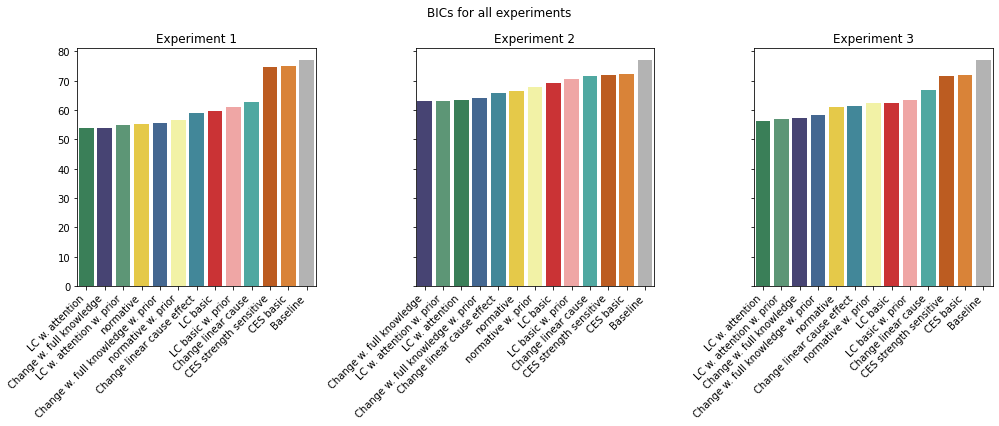

In [379]:

fig, axs = plt.subplots(1, len(experiments), figsize=(14, 6), sharey=True)

for i, experiment in enumerate(experiments):
    df_exp = df_bic[df_bic.experiment == experiment]
    df_exp_plot = df_exp[[col for col in df_exp.columns if col != 'experiment']]
    df_exp_plot = df_exp_plot[df_exp_plot.mean().sort_values().index]

    colors = gen_colors(df_exp_plot.columns, color_dict)
    sns.set_palette(colors)
    sns.barplot(data=df_exp_plot, ax=axs[i], ci=None)
    axs[i].set_xticklabels(df_exp_plot.columns, rotation=45, ha='right')
    axs[i].set_title(f'Experiment {experiment[-1]}')

fig.suptitle('BICs for all experiments')
plt.tight_layout()
plt.show()

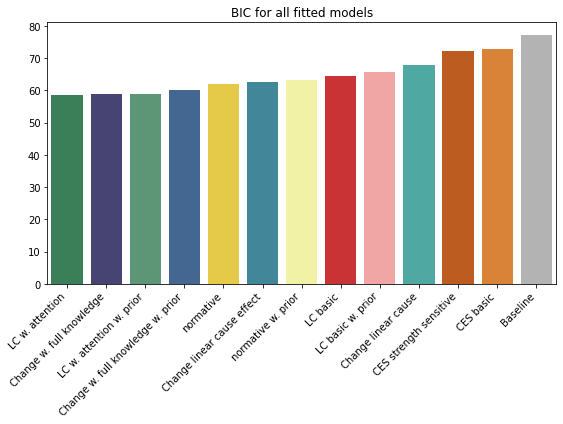

In [380]:
df_bic_plot = df_bic[[col for col in df_bic.columns if col != 'experiment']]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=ax, ci=None)
ax.set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
ax.set_title('BIC for all fitted models')
plt.tight_layout()
plt.show()

In [424]:
select_all = [
    'LC w. attention',
    'LC w. attention w. prior',
    'Change w. full knowledge',
    'Change w. full knowledge w. prior',
    'normative',
    'normative w. prior',
    'LC basic',
    'LC basic w. prior',
    'CES_strength_sensitive',
    'Baseline'
]
select_lc_attention = [
    'LC w. attention',
    'LC w. attention w. prior',
    'Baseline'
]
select_lc = [
    'LC basic',
    'LC basic w. prior',
    'Baseline'
]
select_change = [
    'Change w. full knowledge',
    'Change w. full knowledge w. prior',
    'Change linear cause effect',
    'Change linear cause'
    'Baseline'
]
select_normative = [
    'normative',
    'normative w. prior',
    'Baseline'
]
select_ces = [
    'CES_strength_sensitive',
    'Baseline'
]

selections = {
    'select_all' : [
        'LC w. attention',
        'Change w. full knowledge',
        'normative',
        'LC basic',
        'CES strength sensitive',
        'Baseline'
    ],
    'select_lc_attention' : [
        'LC w. attention',
        'LC w. attention w. prior',
        'Baseline'
    ],
    'select_lc' : [
        'LC basic',
        'LC basic w. prior',
        'Baseline'
    ],
    'select_change' : [
        'Change w. full knowledge',
        'Change linear cause effect',
        'Change linear cause',
        'Baseline'
    ],
    'select_change_prior' : [
        'Change w. full knowledge',
        'Change w. full knowledge w. prior',
        'Baseline'
    ],
    'select_normative' : [
        'normative',
        'normative w. prior',
        'Baseline'
    ],
    'select_ces' : [
        'CES strength sensitive',
        'CES basic',
        'Baseline'
    ]
}

selections_titles = [
    'Key models',
    'Local computations attention models prior comparison',
    'Local computations basic models prior comparison',
    'Change models comparison',
    'Change models prior comparison',
    'Normative models prior comparison',
    'Causal event segmentation models comparison'
]

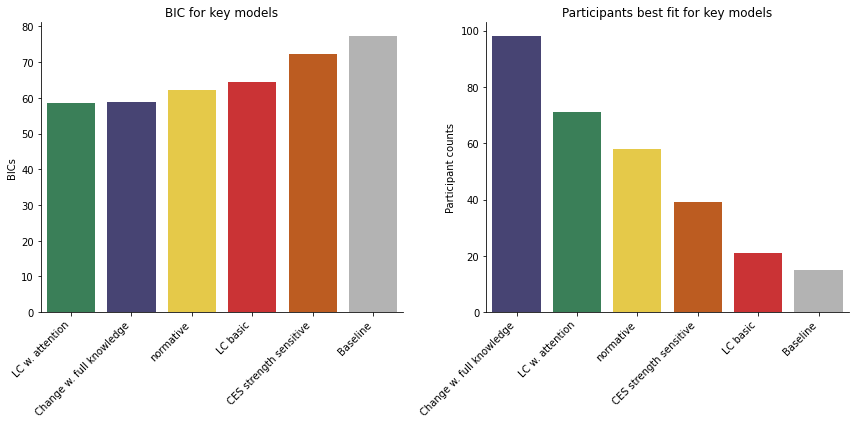

In [406]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
select = 'select_all'

# BICS
df_bic_plot = df_bic[[col for col in df_bic.columns if col not in ['experiment', 'best']]][selections[select]]

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=axs[0], ci=None)
axs[0].set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
axs[0].set_title('BIC for key models')

axs[0].set_ylabel('BICs')

# Participants' best fit

df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

df_bic_plot = df_bic[['best', 'experiment']]

df_order = pd.DataFrame(index=selections[select])
df_order['counts'] = 0
df_order.loc[df_bic_plot.best.value_counts().index, 'counts'] = df_bic_plot.best.value_counts().values

colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
sns.set_palette(colors)

sns.countplot(x='best', data=df_bic_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[1])

axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel('')

axs[1].set_title('Participants best fit for key models')

axs[1].set_ylabel('Participant counts')

sns.despine()
plt.tight_layout()
plt.show()

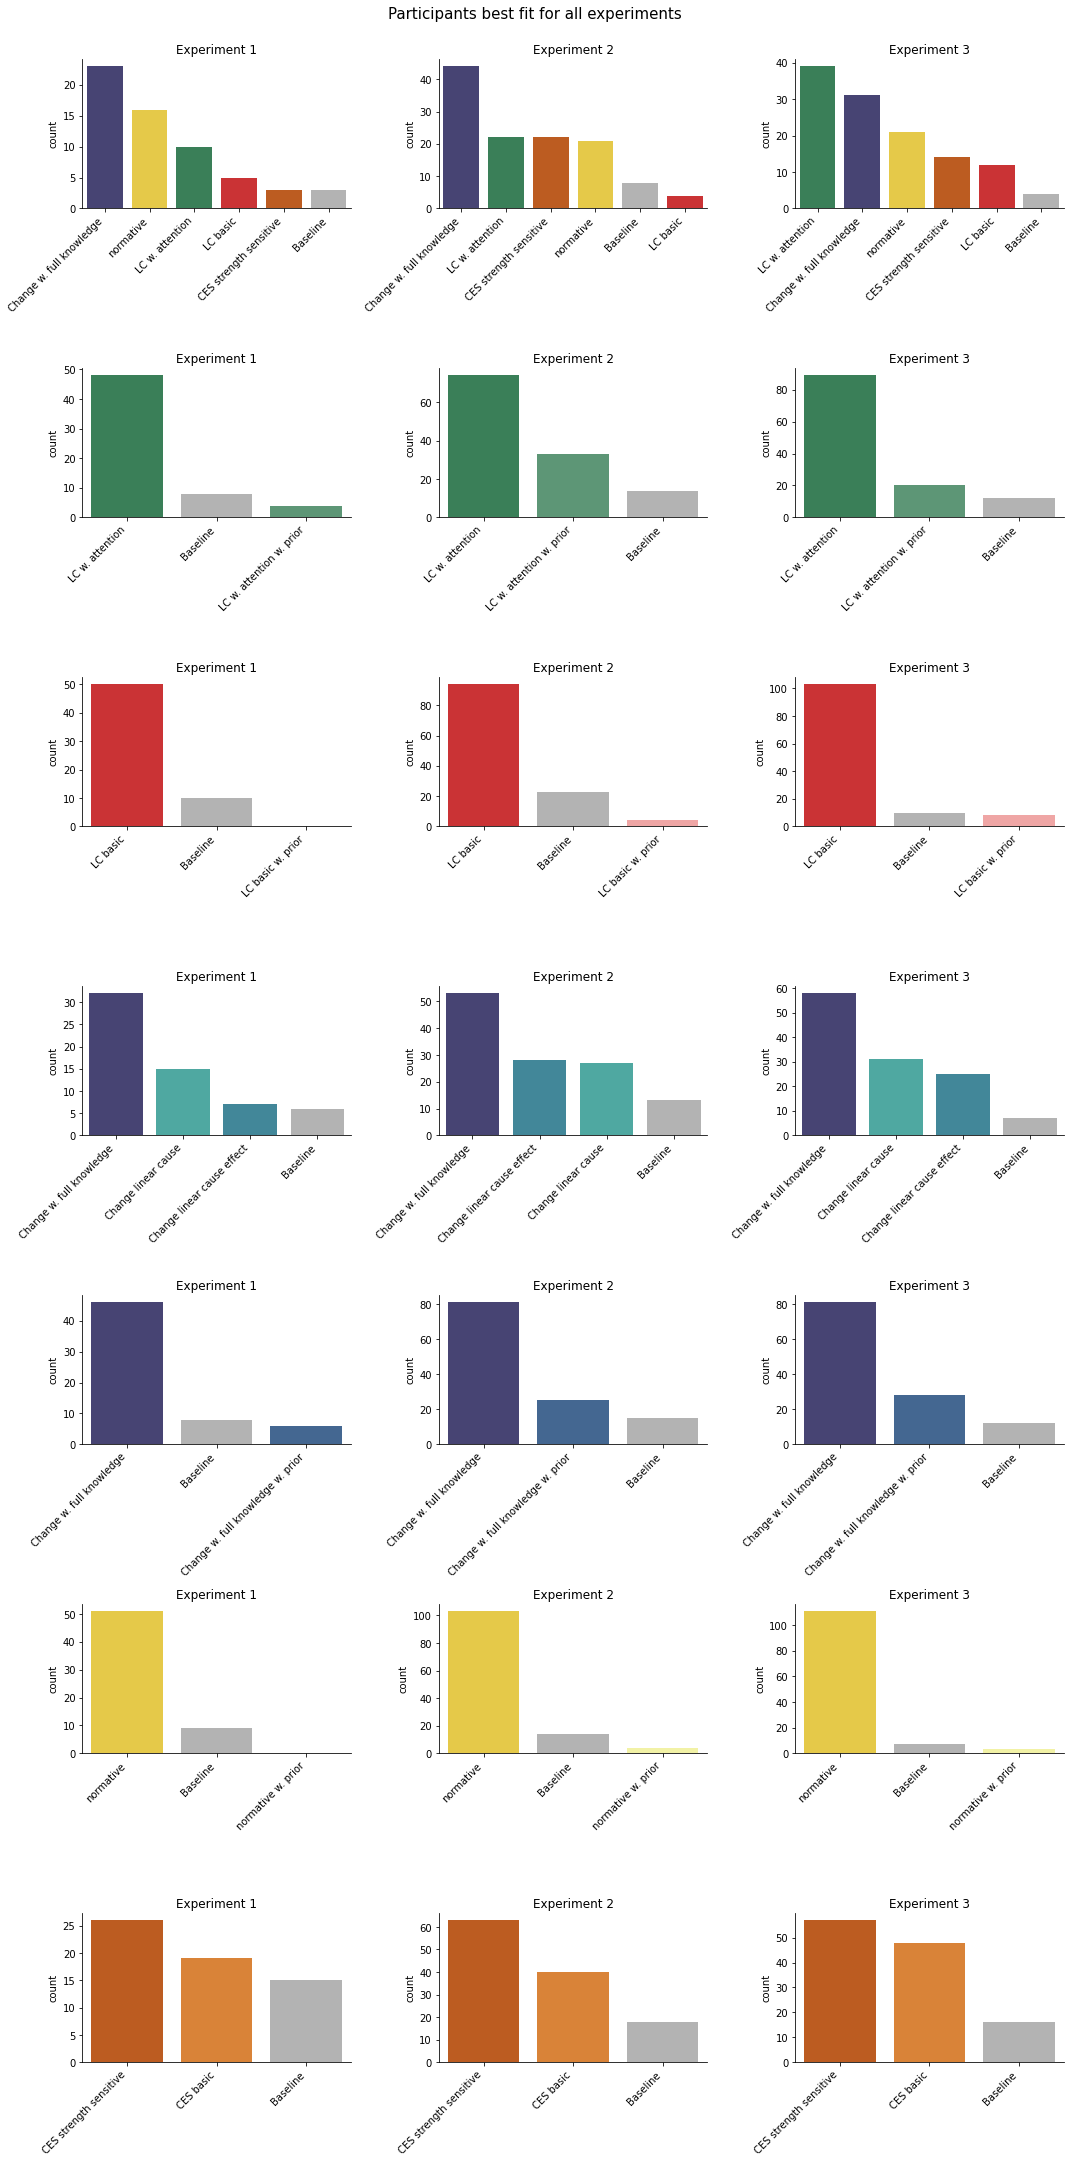

In [405]:
fig, axs = plt.subplots(len(selections), len(experiments), figsize=(15, 30))

for i, select in enumerate(selections.keys()):
    
    df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])
    
    for j, experiment in enumerate(experiments):
        df_exp = df_bic[df_bic.experiment == experiment]
        df_exp_plot = df_exp[['best', 'experiment']]

        df_order = pd.DataFrame(index=selections[select])
        df_order['counts'] = 0
        df_order.loc[df_exp_plot.best.value_counts().index, 'counts'] = df_exp_plot.best.value_counts().values

        colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
        sns.set_palette(colors)

        sns.countplot(x='best', data=df_exp_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[i, j])
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=45, ha='right')
        axs[i, j].set_xlabel('')
        axs[i, j].set_title(f'Experiment {experiment[-1]}')
        
        sns.despine(ax=axs[i, j])

fig.suptitle('Participants best fit for all experiments', fontsize=15, y=1)
plt.tight_layout()
plt.show()
        

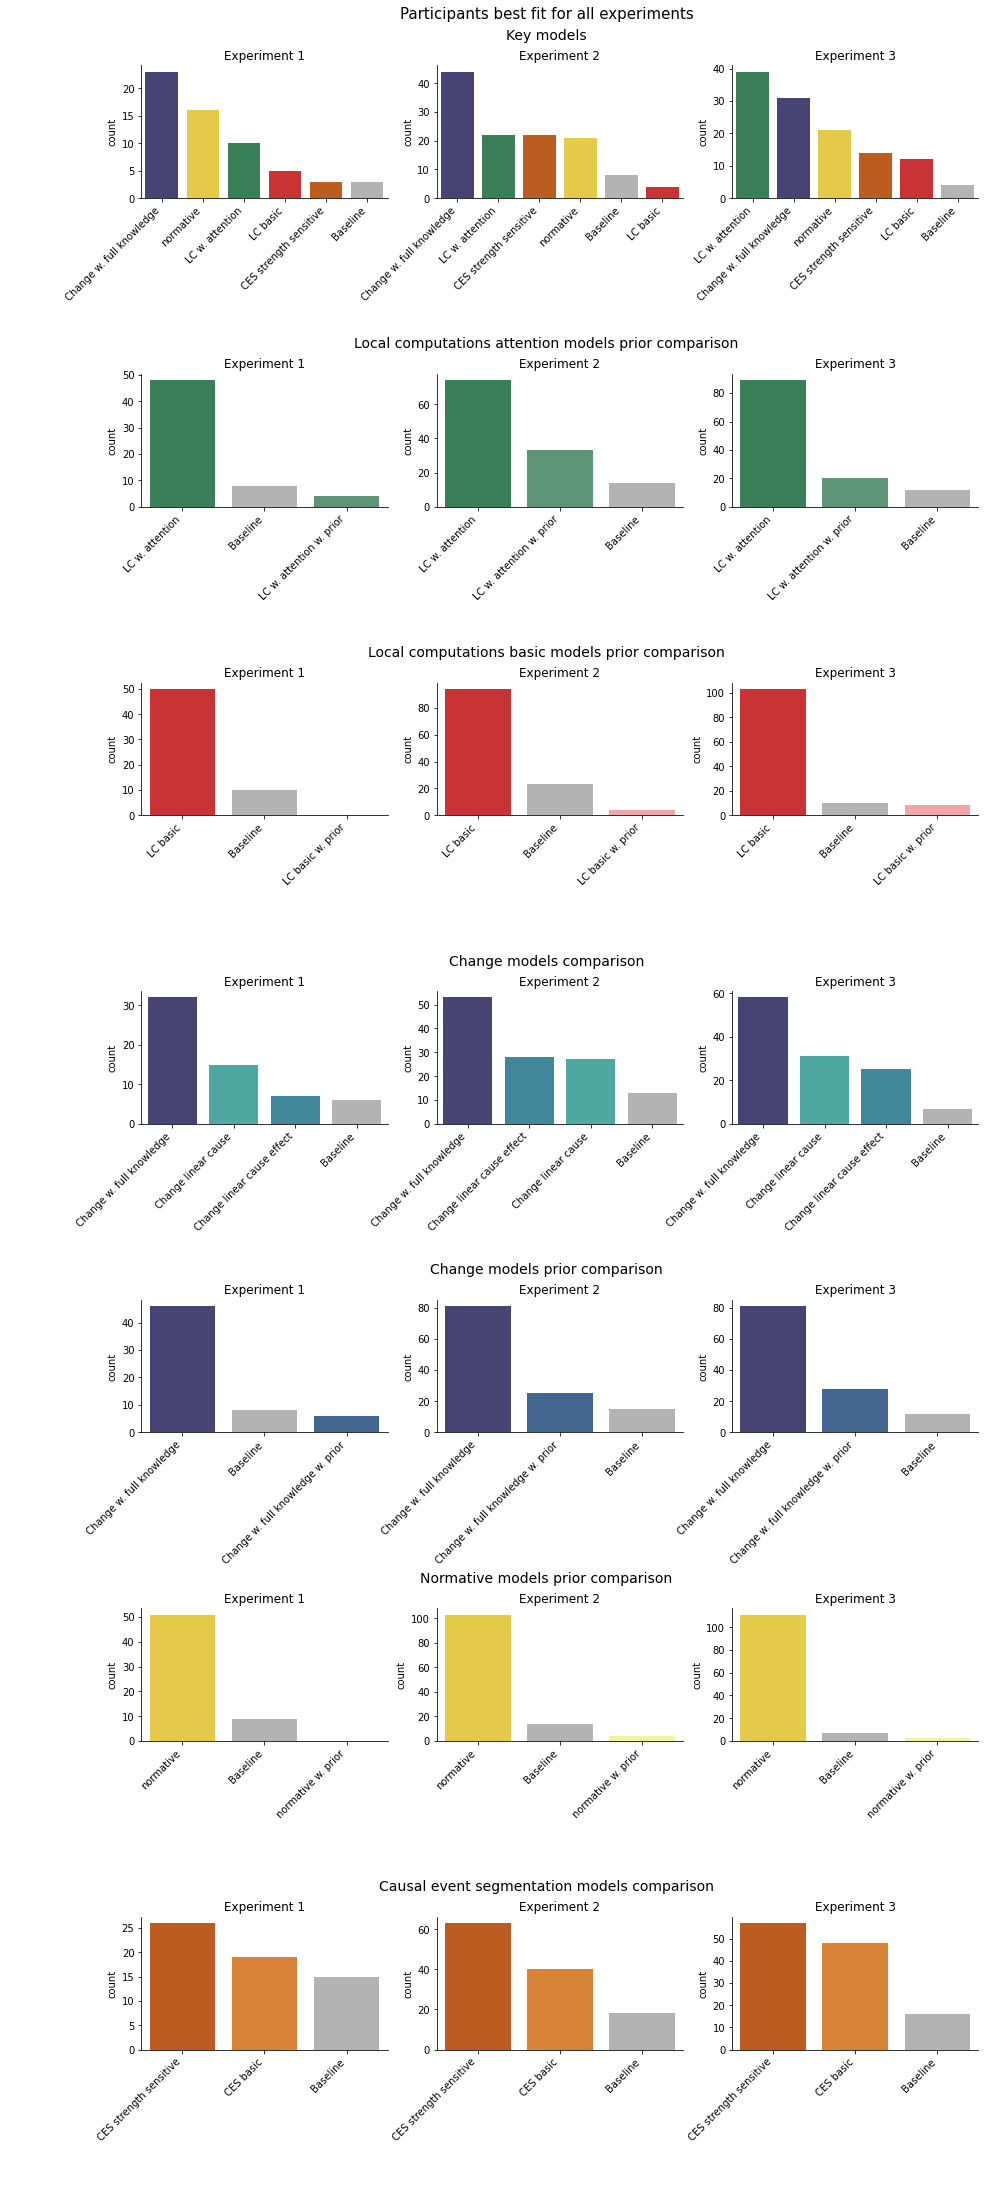

In [430]:
#fig, axs = plt.subplots(len(selections), len(experiments), figsize=(15, 30))

fig = plt.figure(figsize=(15, 30))

subfigs = fig.subfigures(nrows=len(selections), ncols=1)
for i, select in enumerate(selections.keys()):
    subfigs[i].suptitle(f'{selections_titles[i]}', y=1, fontsize=14)

    axs = subfigs[i].subplots(nrows=1, ncols=len(experiments))
    
    df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

    subfigs[i].subplots_adjust(left=None, bottom=0.45, right=None, top=None, wspace=None, hspace=None)
    
    for j, experiment in enumerate(experiments):
        df_exp = df_bic[df_bic.experiment == experiment]
        df_exp_plot = df_exp[['best', 'experiment']]

        df_order = pd.DataFrame(index=selections[select])
        df_order['counts'] = 0
        df_order.loc[df_exp_plot.best.value_counts().index, 'counts'] = df_exp_plot.best.value_counts().values

        colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
        sns.set_palette(colors)

        sns.countplot(x='best', data=df_exp_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[j])
        axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=45, ha='right')
        axs[j].set_xlabel('')
        axs[j].set_title(f'Experiment {experiment[-1]}')
        
        sns.despine(ax=axs[j])

fig.suptitle('Participants best fit for all experiments', fontsize=15, y=1.01)
#plt.tight_layout()
plt.show()

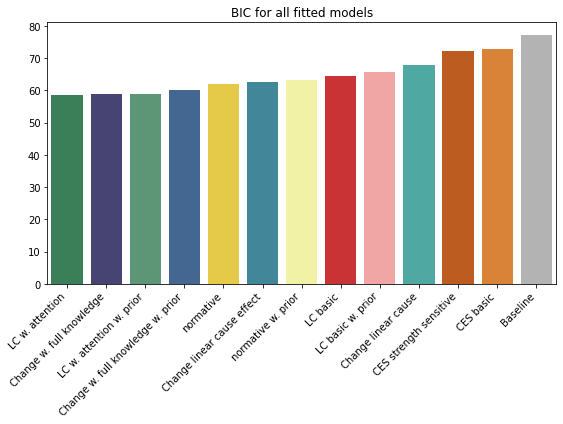

In [388]:
df_bic_plot = df_bic[[col for col in df_bic.columns if col not in ['experiment', 'best']]]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=ax, ci=None)
ax.set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
ax.set_title('BIC for all fitted models')
plt.tight_layout()
plt.show()

In [190]:
select_keys = {
    'attention' : [
        'LC w. attention',
        'LC w. attention w. prior',
        'Baseline'
    ],
    'change' : [
        'Change w. full knowledge',
        'Change w. full knowledge w. prior',
        'Baseline'
    ]
}

for i, select in enumerate(select_keys.keys()):
    df_bic[f'best_{select}'] = df_bic[select_keys[select]].apply(lambda x: np.argmin(x), axis=1)
    df_bic[f'best_{select}'] = df_bic[f'best_{select}'].replace(np.arange(len(select_keys[select])), select_keys[select])

In [195]:
prior_best_attention = df_bic[df_bic.best_attention == 'LC w. attention w. prior'].index
prior_best_change = df_bic[df_bic.best_change == 'Change w. full knowledge w. prior'].index

In [228]:
print(prior_best_attention.size)
print(prior_best_change.size)

intersection = list(set(prior_best_attention).intersection(prior_best_change))

df_prior_att = df[df.model_name.isin(['LC w. attention w. prior'])]
df_prior_change = df[df.model_name.isin(['change w. full knowledge w. prior'])]
df_prior = df[df.model_name.isin(['LC w. attention w. prior', 'change w. full knowledge w. prior'])]

54
46


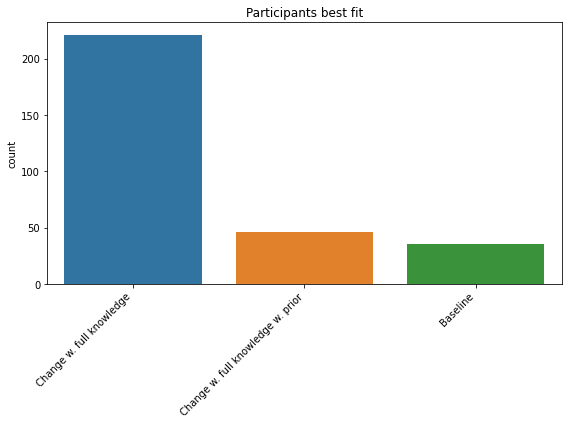